# Model 2: Anatomically accurate model of Amygdala

1. target behavioral data
    - conditioned fear response
    - extinction-induced reduction of fear response
    - renewal of fear response when the CS is presented in the original context
2. target activity data
    - LA pyramidal neurons (PN) become CS-responsive after conditioning
    - LA pyramidal neurons (PN) maintain CS-responsiveness after extinction
    - LA inhibitory neurons (PV and SOM) respond to the US, releasing inhibition of LA pyramidal cells
    - BLA fear neurons (excitatory) become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons (excitatory) become CS-responsive after extinction
    - BLA persistent neurons (excitatory) become CS-responsive after conditioning and maintain their activity after extinction
    - CeL "on" neurons (inhibitory) become more responsive to CS following conditioning
    - CeL "off" neurons (inhibitory) become less responsive to CS following conditioning


In [18]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [19]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
        self.pause = False
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied and not self.pause else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [20]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
intercept_LA_pyr = -0.2
lr = 5e-5

rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
dInh = -3e0*np.ones((nNeurons, 1))

## Version 1
 - LA pyramidal and interneurons; functionally similar to model 1.1. LA neurons are divided into those response to US and those responsive to CS
 - PES learning updates connections weights from external_CS to LA_pyr, such that LA_pyr's CS response increases when the US is present alongside the CS
 - LA_inh receives CS and US information from external_CS and external_US via fixed connections, then gates learning in LA_pyr via inhibition

In [21]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    # prevent learning during testing
    nengo.Connection(stop_learning, error_LA.neurons, transform=dInh)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pError_LA = nengo.Probe(error_LA)

In [22]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


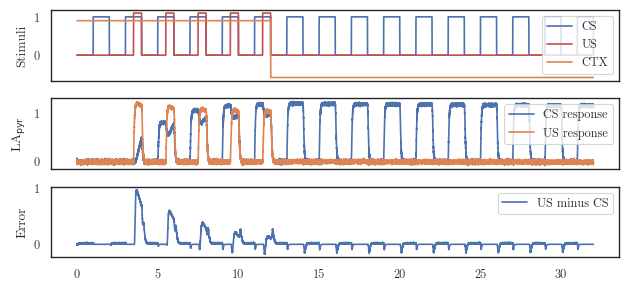

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((6.38,3)), gridspec_kw={'height_ratios': [2,2,2]})
axes[0].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS")
axes[0].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), 0.9*np.dot(sim.data[pCTX], inputs.CTXs[0]), label='CTX')
axes[0].legend(loc='upper right')
axes[0].set(yticks=((0,1)), ylabel="Stimuli")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="CS response")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="US response")
axes[1].legend(loc='upper right')
axes[1].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel="LA"+r"$_{\mathrm{pyr}}$")
axes[2].plot(sim.trange(), sim.data[pError_LA], label="US minus CS")
axes[2].legend()
axes[2].set(ylabel="Error", yticks=((0,1)))
plt.tight_layout()
fig.savefig("amy2v1_dynamics.svg")
fig.savefig("amy2v1_dynamics.png", dpi=600)

34.0% of LA neurons become more CS responsive, 39.5% become less CS responsive


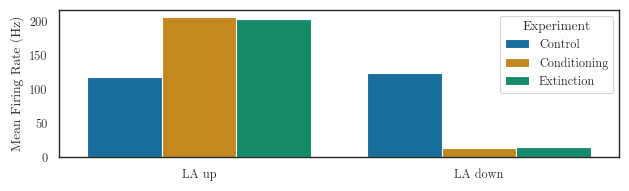

In [8]:
T1a = int(1/dt)
T1b = int(2/dt)
T2a = int((2+2*nCond-1)/dt)
T2b = int((2+2*nCond-0.5)/dt)
T3a = int((2+2*nCond+2*nExt-1)/dt)
T3b = int((2+2*nCond+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
            
aControl_LA_pyr = sim.data[pLA_pyr_spikes][T1a: T1b]
aConditioning_LA_pyr = sim.data[pLA_pyr_spikes][T2a: T2b]
aExtinction_LA_pyr = sim.data[pLA_pyr_spikes][T3a: T3b]
LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]

data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38,2)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)")
plt.tight_layout()
fig.savefig("model2_LA_responses.svg")
fig.savefig("model2_LA_responses.png", dpi=600)

percent_up = len(LA_pyr_up)/(2*nNeurons)*100
percent_down = len(LA_pyr_down)/(2*nNeurons)*100
print(f"{percent_up}% of LA neurons become more CS responsive, {percent_down}% become less CS responsive")

## Version 2
 - adds CeL and CeM. These populations convey LA_pyr output (learned CS responses) to the amygdala's output, causing fear response
 - PES learning updates connections weights from LA_pyr to CeL, such that CeL's CS response increases when the US is present alongside the CS
 - A constant bias is sent to CeM and to one dimension of CeL. This causes CeM, and some neurons in CeL, to fire without external input. These spontaneously active CeL cells inhibit CeM, such that, with no external input, CeM is quiet, and no fear response occurs
 - When CeL becomes conditioned to respond to CS via learned projections from LA, CS-responsive CeL neurons compete with spontaneously active CeL neurons to activate CeM, causing fear response. We realize this competition via a functional connection from CeL (CS-response minus bias); biologically, this likely happens through lateral inhibition in CeL and disinhibition of CeM.

In [10]:
lr1 = 5e-5
lr2 = 5e-4

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03

intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 1.0)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off)
    nengo.Connection(bias, CeM)
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)

In [11]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


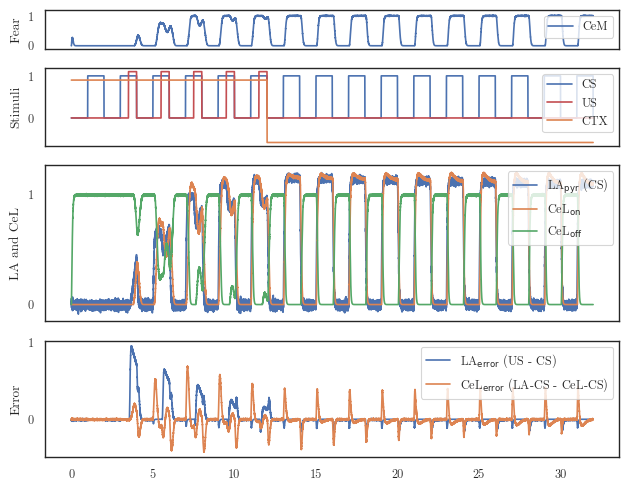

In [17]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((6.38,5)), gridspec_kw={'height_ratios': [1,2,4,3]})
axes[0].plot(sim.trange(), sim.data[pCeM], label='CeM')
axes[0].set(yticks=((0, 1)), ylim=((-0.1, 1.2)), ylabel="Fear")
axes[0].legend(loc='upper right')
axes[1].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS")
axes[1].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), 0.9*np.dot(sim.data[pCTX], inputs.CTXs[0]), label='CTX')
axes[1].legend(loc='upper right')
axes[1].set(yticks=((0,1)), ylabel="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label=r"LA$_{\mathrm{pyr}}$ (CS)")
axes[2].plot(sim.trange(), sim.data[pCeL_on], label="CeL$_{\mathrm{on}}$")
axes[2].plot(sim.trange(), sim.data[pCeL_off], label="CeL$_{\mathrm{off}}$")
axes[2].legend(loc='upper right')
axes[2].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel="LA and CeL")
axes[3].plot(sim.trange(), sim.data[pError_LA], label=r"LA$_{\mathrm{error}}$ (US - CS)")
axes[3].plot(sim.trange(), sim.data[pError_CeL], label=r"CeL$_{\mathrm{error}}$ (LA-CS - CeL-CS)")
axes[3].legend(loc='upper right')
axes[3].set(ylabel="Error", yticks=((0,1)))
plt.tight_layout()
fig.savefig("amy2v2_dynamics.svg")
fig.savefig("amy2v2_dynamics.png", dpi=600)

## Version 3
 - return to version 1, then add a BLA, which includes BLA_pyramidal and BLA_interneurons. Functionally similar to model1.3
 - BLA_pyr and BLA_inh receive [CS, US] information from LA_pyr
 - BLA_pyr receives an external connection conveying CTX information. Use PES learning on this connection such that two trends occur (mediated by separate error populations):
    - when CTX is present alongside US, learn a fear association between the two (error = BLA_US - BLA_CTX). This error should be inhibited unless the US is present
    - when CTX is present alongside BLA_CS response, but no US is present, learn a safety association between CTX and CS (error = BLA_CS - BLA_CTX) (technically CS + CTX, because BLA_CTX representation becomes negative)
 - BLA_inh gates the BLA_error populations appropriately, given CS and US information

In [24]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
intercept_LA_pyr = -0.2
intercept_BLA_pyr = 0.0
lr1 = 3e-5
lr2 = 3e-4
lr3 = 1e-5

rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_BLA_pyr = sampler.sample(3*nNeurons, 3, rng=rng)
intercepts_BLA_pyr = nengo.dists.Uniform(intercept_BLA_pyr, intercept_BLA_pyr)

dInh = -3e0*np.ones((nNeurons, 1))

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03
    
with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 0.5)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    error_BLA_safe = nengo.Ensemble(nNeurons, 1)
    error_BLA_fear = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off, transform=1)
    nengo.Connection(bias, CeM)
    nengo.Connection(CTX, external_CTX, synapse=None)
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
    nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
    nengo.Connection(BLA_pyr[0], CeM, transform=0.25)  # CS response added to total fear response
    nengo.Connection(BLA_pyr[2], CeM, transform=0.75)  # CTX response added to total fear response
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
    extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
#     nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
#     nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
    nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
    nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
    nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
    nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
#     nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
    nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
    pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pBLA_inh_long = nengo.Probe(BLA_inh[1], synapse=0.3)
    pError_BLA_safe = nengo.Probe(error_BLA_safe)
    pError_BLA_fear = nengo.Probe(error_BLA_fear)    

In [25]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


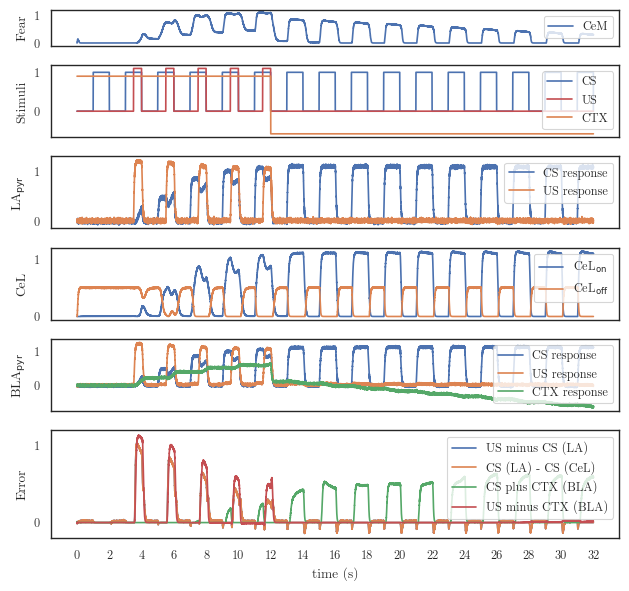

In [28]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=((6.38,6)), gridspec_kw={'height_ratios': [1,2,2,2,2,3]})
axes[0].plot(sim.trange(), sim.data[pCeM], label='CeM')
axes[0].set(yticks=((0, 1)), ylim=((-0.1, 1.2)), ylabel="Fear")
axes[0].legend(loc='upper right')
axes[1].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS")
axes[1].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), 0.9*np.dot(sim.data[pCTX], inputs.CTXs[0]), label='CTX')
axes[1].legend(loc='upper right')
axes[1].set(yticks=((0,1)), ylabel="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="CS response")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="US response")
axes[2].legend(loc='upper right')
axes[2].set(yticks=((0, 1)), ylabel=r"LA$_\mathrm{pyr}$")
axes[3].plot(sim.trange(), sim.data[pCeL_on], label="CeL$_\mathrm{on}$")
axes[3].plot(sim.trange(), sim.data[pCeL_off], label="CeL$_\mathrm{off}$")
axes[3].legend(loc='upper right')
axes[3].set(yticks=((0, 1)), ylabel="CeL")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,0], label="CS response")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,1], label="US response")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,2], label="CTX response")
axes[4].legend(loc='upper right')
axes[4].set(yticks=((0, 1)), ylabel="BLA$_\mathrm{pyr}$")
axes[5].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (LA)")
axes[5].plot(sim.trange(), sim.data[pError_LA], label="CS (LA) - CS (CeL)")
axes[5].plot(sim.trange(), sim.data[pError_BLA_safe], label="CS plus CTX (BLA)")
axes[5].plot(sim.trange(), sim.data[pError_BLA_fear], label="US minus CTX (BLA)")
axes[5].legend(loc='upper right')
axes[5].set(xlabel='time (s)', xticks=np.arange(0, 34, 2), ylabel="Error", yticks=((0,1)))
plt.tight_layout()
fig.savefig("amy2v3_dynamics.svg")
fig.savefig("amy2v3_dynamics.png", dpi=600)

percent fear: 6.75
percent extinction: 10.50
percent persistent: 29.50


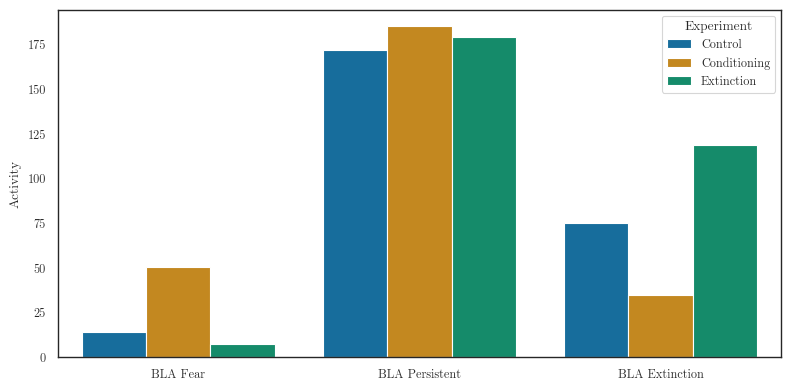

In [15]:
T1a = int(1/dt)
T1b = int(2/dt)
T4a = int((2+2*nCond-1)/dt)
T4b = int((2+2*nCond-0.5)/dt)
T5a = int((2+2*nCond+2*nExt-1)/dt)
T5b = int((2+2*nCond+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])

aControl_BLA = sim.data[pBLA_pyr_spikes][T1a: T1b]
aConditioning_BLA = sim.data[pBLA_pyr_spikes][T4a: T4b]
aExtinction_BLA = sim.data[pBLA_pyr_spikes][T5a: T5b]    
fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

percent_fear = len(fear_neurons)/(4*nNeurons)*100
percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
percent_persistent = len(persistent_neurons)/(4*nNeurons)*100

print(f"percent fear: {percent_fear:.2f}")
print(f"percent extinction: {percent_extinction:.2f}")
print(f"percent persistent: {percent_persistent:.2f}")

data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()